### Offense-Defense Custom Rating 2019

#### Libraries

In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(lplyr,warn.conflicts=F)
library(tidyr,warn.conflicts=F)
library(tidyimpute,warn.conflicts=F)

library(psych,warn.conflicts=F)
library(ggplot2,warn.conflicts=F)

#### Load 2019

In [2]:
# load the stats
data.regulars <- read.csv('../2019//RegularSeasonDetailedResults.csv',stringsAsFactors=F)
# keep 2011+
data.regulars %>% filter(Season==2019) -> data.regulars

In [3]:
# load the stats
data.teams <- readRDS('../datafiles_rds/Teams.rds')

data.teams %>%
    select(TeamID,TeamName) %>%
    mutate(TeamName=str_to_lower(TeamName), 
           TeamName=str_replace_all(TeamName,' ','_'), 
           TeamName=str_remove_all(TeamName,'&')) -> df.teams

#### Prepare data

In [4]:
data.regulars %>% dim %>% cat
data.regulars %>% head

5463 34

Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,⋯,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2019,1,1104,82,1380,62,H,0,27,55,⋯,17,17,30,11,20,8,15,7,2,28
2019,1,1113,102,1168,94,H,0,33,78,⋯,24,19,26,7,35,7,17,7,3,36
2019,1,1119,73,1265,69,H,0,22,51,⋯,15,12,24,9,27,8,12,4,0,23
2019,1,1120,101,1375,58,H,0,38,74,⋯,22,17,22,8,19,9,22,4,5,17
2019,1,1123,86,1232,69,H,0,32,65,⋯,12,11,18,18,20,11,11,6,5,20
2019,1,1130,73,1454,53,H,0,22,56,⋯,27,9,13,13,25,13,8,1,5,25


In [5]:
data.regulars %>% 
    rename_at(vars(starts_with('L')),list(~str_replace(.,'L','O'))) %>%
    rename_at(vars(starts_with('W')),list(~str_remove(.,'W'))) %>%
    mutate(OLoc=case_when(Loc=='H' ~ 'A', Loc=='A' ~ 'H', TRUE ~ 'N')) -> group1
data.regulars %>% 
    rename_at(vars(starts_with('L')),list(~str_remove(.,'L'))) %>%
    rename_at(vars(starts_with('W')),list(~str_replace(.,'W','O'))) %>%
    mutate(Loc=case_when(OLoc=='H' ~ 'A', OLoc=='A' ~ 'H', TRUE ~ 'N')) -> group2
group1 %>% bind_rows(group2) -> df.regulars

In [6]:
df.regulars %>% dim %>% cat('\n')
df.regulars %>% arrange(Season,DayNum) %>% head

10926 35 


Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,OLoc
2019,1,1104,82,1380,62,H,0,27,55,⋯,17,30,11,20,8,15,7,2,28,A
2019,1,1113,102,1168,94,H,0,33,78,⋯,19,26,7,35,7,17,7,3,36,A
2019,1,1119,73,1265,69,H,0,22,51,⋯,12,24,9,27,8,12,4,0,23,A
2019,1,1120,101,1375,58,H,0,38,74,⋯,17,22,8,19,9,22,4,5,17,A
2019,1,1123,86,1232,69,H,0,32,65,⋯,11,18,18,20,11,11,6,5,20,A
2019,1,1130,73,1454,53,H,0,22,56,⋯,9,13,13,25,13,8,1,5,25,A


In [7]:
df.regulars %>%
    left_join(df.teams %>% rename(OTeamName=TeamName),by=c('OTeamID'='TeamID')) %>%
    left_join(df.teams,by='TeamID') -> df.regulars

#### Stat matrix

In [8]:
CreateMatrix <- function(dataset,stat) {
    stat_var <- enquo(stat)
    dataset %>% rename(Statistic := !!stat_var) -> dataset
    for(i in 2019:2019) {
        dataset %>%
            filter(Season==i) %>%
            select(TeamName,OTeamName,Statistic) %>% 
            group_by(TeamName,OTeamName) %>% 
            summarise(Statistic=mean(Statistic)) %>% 
            ungroup() %>%
            spread(TeamName,Statistic) %>% 
            impute(0.01) %>% 
            select(-OTeamName) %>% 
            as.matrix() -> tmp
        dataset %>% 
            filter(Season==i) %>% 
            distinct(OTeamName) %>% 
            arrange(OTeamName) %>% 
            pull(OTeamName) -> vnames
        attr(tmp,'dimnames') <- list(vnames,vnames)
        assign(paste0('m.stat.',i), tmp, envir=.GlobalEnv)
    }
}

In [9]:
dataset <- df.regulars %>% 
    mutate(Poss=FGA+0.475*FTA-OR+TO,ScorePoss=Score/Poss) %>%
    mutate(OPoss=OFGA+0.475*OFTA-OOR+OTO,OScorePoss=OScore/OPoss) %>%
    mutate(GmS=(ScorePoss+1)/(ScorePoss+OScorePoss+2))

In [10]:
dataset %>% head

Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OBlk,OPF,OLoc,OTeamName,TeamName,Poss,ScorePoss,OPoss,OScorePoss,GmS
2019,1,1104,82,1380,62,H,0,27,55,⋯,2,28,A,southern_univ,alabama,72.300,1.134163,73.250,0.8464164,0.5361438
2019,1,1113,102,1168,94,H,0,33,78,⋯,3,36,A,cs_fullerton,arizona_st,95.900,1.063608,96.350,0.9756098,0.5108930
2019,1,1119,73,1265,69,H,0,22,51,⋯,0,23,A,marist,army,64.775,1.126978,66.400,1.0391566,0.5105399
2019,1,1120,101,1375,58,H,0,38,74,⋯,5,17,A,south_alabama,auburn,74.650,1.352981,70.450,0.8232789,0.5634182
2019,1,1123,86,1232,69,H,0,32,65,⋯,5,20,A,indiana_st,ball_st,67.500,1.274074,68.550,1.0065646,0.5312465
2019,1,1130,73,1454,53,H,0,22,56,⋯,5,25,A,wi_milwaukee,boston_college,65.200,1.119632,66.175,0.8009067,0.5406481


In [11]:
CreateMatrix(dataset,GmS)

####  Offense-Defense Rating

In [12]:
ComputeRating <- function(A) {
    dnow <- rep(1,nrow(A))
    for(i in 1:100) {
        dprev <- dnow
        dnow <- A %*% (1/(t(A) %*% (1/dprev)))
    }
    rdef <- as.vector(dnow)
    roff <- as.vector(t(A) %*% (1/rdef))
    rating <- as.vector(roff / rdef)
    data.frame(Team=attr(A,'dimnames')[[2]],Rating=rating,Offense=roff,Defense=rdef)
}

In [13]:
ComputeRating(m.stat.2019) %>% 
    mutate(Season=2019) %>% 
    mutate_if(is.factor,as.character) -> df.ratings

In [14]:
df.ratings %>% arrange(desc(Rating)) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% select(Season,everything())

Season,Team,Rating,Offense,Defense
2019,virginia,16.36379,16.31891,0.9972575


###  Regular seasons performance (train dataset)

In [15]:
data.regulars %>% 
    select(Season,WTeamID,LTeamID) %>%
    mutate(TeamID.x = ifelse(WTeamID<LTeamID,WTeamID,LTeamID), 
           TeamID.y = ifelse(WTeamID<LTeamID,LTeamID,WTeamID),
           Target = ifelse(TeamID.x==WTeamID,1,0),
           ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>%
    select(-WTeamID,-LTeamID) -> df.train

In [16]:
df.ratings %>%
    left_join(df.teams,by=c('Team'='TeamName')) -> df.ratings

In [17]:
df.train %>%
    select(-Target,-ID) %>%
    inner_join(df.ratings,by=c('Season','TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team) %>%
    inner_join(df.ratings,by=c('Season','TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> data.train.matchups

In [18]:
data.train.matchups %>% sample_n(5)

Season,TeamID.x,TeamID.y,Rating.x,Rating.y
2019,1299,1422,13.62947,14.60860
2019,1310,1461,13.63420,13.48455
2019,1178,1259,13.81192,13.67376
2019,1116,1161,14.76521,14.12765
2019,1156,1354,13.79886,13.16798


In [19]:
# slope hyper parameter grid : we will compute 80 models and chose the best one (min logloss)
df.ratings %>% 
    mutate(dummy=1) %>% 
    inner_join(data.frame(qtl=seq(0.01,0.95,0.01),dummy=1),by='dummy') %>% 
    select(-dummy) %>% 
    group_by(Season,qtl) %>% 
    mutate(thres=max(Rating)-quantile(Rating,max(qtl)),Slope=3/thres) %>%
    ungroup %>% 
    select(Season,qtl,Slope) %>% 
    distinct() -> df.slopes
df.slopes %>% sample_n(5)

Season,qtl,Slope
2019,0.10,1.023710
2019,0.53,1.376451
2019,0.54,1.393926
2019,0.41,1.256013
2019,0.45,1.284031


In [20]:
data.train.matchups %>% 
    inner_join(df.slopes,by=c('Season')) -> data.train.matchups
data.train.matchups %>% dim %>% cat('\n')
data.train.matchups %>% sample_n(5)

518985 7 


Season,TeamID.x,TeamID.y,Rating.x,Rating.y,qtl,Slope
2019,1157,1421,14.16795,12.72832,0.07,0.987734
2019,1223,1394,13.70035,13.74260,0.93,2.808415
2019,1297,1460,14.58069,14.38101,0.26,1.148392
2019,1299,1422,13.62947,14.60860,0.69,1.653834
2019,1346,1392,13.98962,14.25911,0.62,1.536897


In [21]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
data.train.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(Season,qtl,ID,Pred,Prob) -> df.train.submit
df.train.submit %>% sample_n(5)

Season,qtl,ID,Pred,Prob
2019,0.84,2019_1260_1386,1,0.714
2019,0.08,2019_1206_1241,1,0.669
2019,0.68,2019_1263_1436,0,0.067
2019,0.14,2019_1313_1366,1,0.684
2019,0.68,2019_1184_1398,1,0.626


In [22]:
# merge prediction and truth
df.train %>% select(ID,Target) -> data.train.truth
data.train.truth %>% inner_join(df.train.submit,by='ID') -> df.train.results

In [23]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.train.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(Season,qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(Season,qtl,TC,FC,N,Acc,LogLoss) -> df.train.perf
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() 

Season,qtl,TC,FC,N,Acc,LogLoss
2019,0.84,6607,2508,9115,0.7248491,0.5318158


In [24]:
df.train.perf %>% distinct(Season,Acc) %>% spread(Season,Acc,sep='_') %>%
    mutate(Stat='Accuracy') %>% select(Stat,everything()) -> tmp01
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,LogLoss) %>% spread(Season,LogLoss,sep='_') %>% mutate(Stat='Best LogLoss') %>% select(Stat,everything()) -> tmp02
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,qtl) %>% spread(Season,qtl,sep='_') %>% mutate(Stat='Best Quantile') %>% select(Stat,everything()) -> tmp03
tmp01 %>% bind_rows(tmp02) %>% bind_rows(tmp03)

Stat,Season_2019
Accuracy,0.7248491
Best LogLoss,0.5318158
Best Quantile,0.8400000


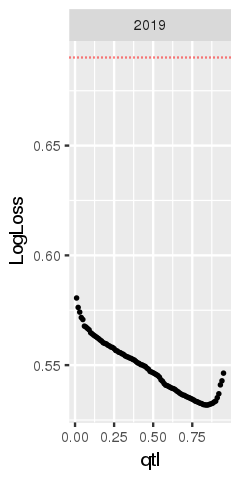

In [25]:
options(repr.plot.width=2, repr.plot.height=4)
ggplot(data=df.train.perf,aes(x=qtl,y=LogLoss)) + 
    geom_point(size=0.5) + 
    geom_hline(yintercept=0.69,color='red',linetype="dotted") +
    facet_grid(. ~ Season)

### Tourney matchups performance (validation dataset)

#### Load test data

In [40]:
data.madnessteams <- read.csv('../2019//NCAATourneySeeds.csv',stringsAsFactors=F)
data.madnessteams %>% 
    filter(Season==2019) %>%
    select(TeamID) %>% 
    mutate(dummy=1) -> data.madnessteams

In [54]:
data.madnessteams %>%
    full_join(data.madnessteams,by='dummy') %>%
    filter(TeamID.x < TeamID.y) %>%
    select(-dummy) -> data.matchups 

#### prepare

In [56]:
data.matchups %>%
    inner_join(df.ratings,by=c('TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team,-Season) %>%
    inner_join(df.ratings,by=c('TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> df.matchups  

In [57]:
df.matchups %>% head

TeamID.x,TeamID.y,Rating.x,Rating.y,Season
1181,1277,16.35624,15.94483,2019
1181,1261,16.35624,15.36977,2019
1181,1439,16.35624,15.84544,2019
1181,1280,16.35624,15.32671,2019
1181,1268,16.35624,15.19677,2019
1181,1257,16.35624,15.37857,2019


In [58]:
# compare 2019 Train LogLoss curve to 2011-2018 Train LogCurve => best match = 2014 | 2018  => Validation QTL ~ 0.61 to 0.65 
df.slopes %>% filter(qtl==0.6) %>% pull(Slope) -> Slope

In [60]:
df.matchups %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(ID,Pred,Prob) -> df.submit
df.submit %>% arrange(ID) %>% head

ID,Pred,Prob
2019_1101_1113,0,0.336
2019_1101_1120,0,0.149
2019_1101_1124,0,0.289
2019_1101_1125,0,0.319
2019_1101_1133,1,0.557
2019_1101_1138,0,0.203


In [62]:
# save the best results for kaggle submission
df.submit %>% 
    select(ID,Pred=Prob) %>% 
    write.csv('../predictions_2019/OffDef_ScorePoss_Laplace.csv',quote=F,row.names=F)

In [63]:
# save best model for mix
df.submit %>%
    saveRDS('../predictions_2019/OffDef_ScorePoss_Laplace.rds') 